<a href="https://colab.research.google.com/github/sayedmohamedscu/DinoV3/blob/main/DinoV3_Explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## access and [download your model ](https://github.com/facebookresearch/dinov3?tab=readme-ov-file#pretrained-models)



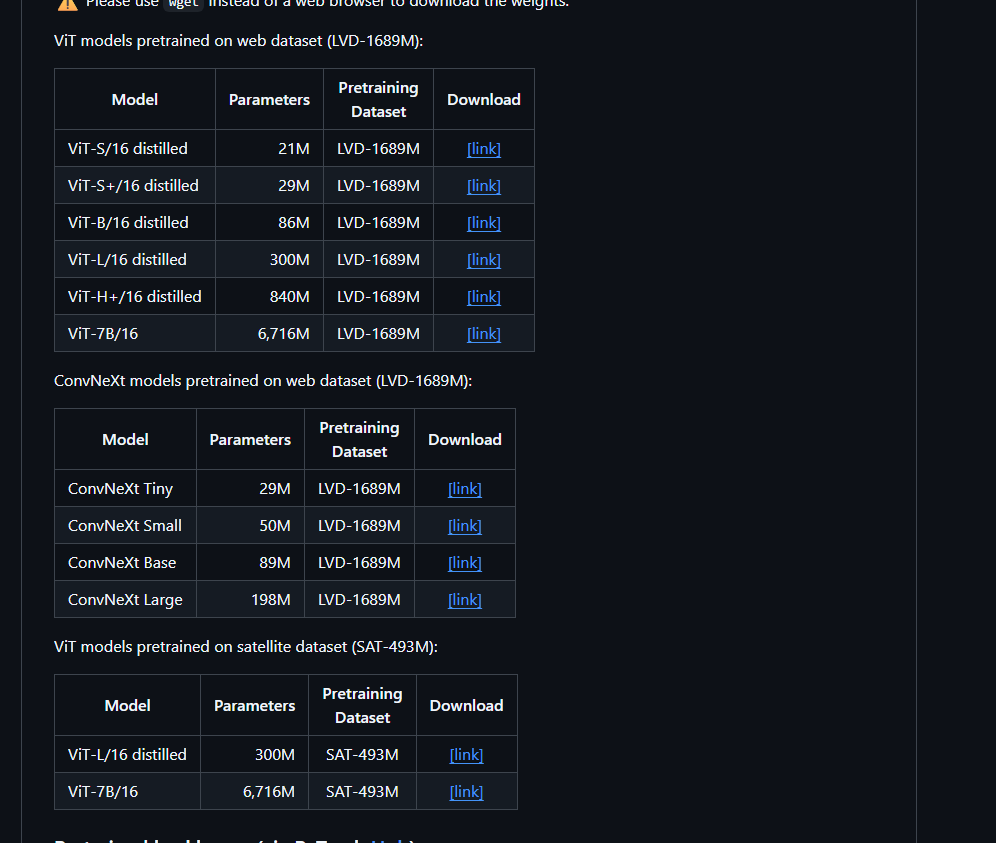

# Patches Similarty

In [1]:
#!wget -O "dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth" "https://dinov3.llamameta.net/dinov3_vit7b16/dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth?Policy=eyJTdGF0ZW1lbnQiOlt7In..............."


--2025-08-21 00:09:44--  https://dinov3.llamameta.net/dinov3_vith16plus/dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoia2l1eDRleDdtM3BhYWg5YjEya3NrNHRjIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTU3ODUxMzh9fX1dfQ__&Signature=jI%7EENyJsUv4avFabXauBMl%7EWgsHL-QzjN%7Ezuyoo8bCRSFo4o7KanygwlftifEQoByoQAiBQ1lHRMOTcN2J0k9WpLnY9-kVRIJBhxKHrZQi4oHi%7Ej9-rjmo%7E%7ENpmbimBIl9xjTRofKZC75k0e5Y3YNouE20cdlgtAsXpDaHpgET-VY5ZFn-AfDoZid4ePfxdN7DRUBqNiXIGRV2KE5JEYrO5llxxnCltWsZX9gkiKT%7Eb2TDlf0eGJ8lE521mHkrEzaIsFmUCjq6GOWATPj8jEZ0FUpoUra4cHt1kA2eb4u7MFnZpbaDUIDDGh1K59r%7E9sN6pbKxUdkDirzM1K41oowA__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1486331912504281
Resolving dinov3.llamameta.net (dinov3.llamameta.net)... 18.155.68.124, 18.155.68.78, 18.155.68.37, ...
Connecting to dinov3.llamameta.net (dinov3.llamameta.net)|18.155.68.124|:443... connected.
HTTP request sent, aw

In [3]:
import os
import torch
import torch.nn.functional as F
import gradio as gr
import numpy as np
from PIL import Image, ImageDraw
import torchvision.transforms.functional as TF
from matplotlib import colormaps

# ----------------------------
# Config
# ----------------------------
MODEL_REPO = "facebookresearch/dinov3"
MODEL_NAME = "dinov3_vith16plus"   # DINOv3 ViT-*-16 (H/16+ in your checkpoint)
PATCH_SIZE = 16                    # image is processed on a 16px patch grid
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# ----------------------------
# Model Loading (local checkpoint)
# ----------------------------
DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"
DINOV3_LOCATION = os.getenv("DINOV3_LOCATION", DINOV3_GITHUB_LOCATION)
print(f"DINOv3 location set to {DINOV3_LOCATION}")

# Build the architecture only (skip the URL download)
model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local" if DINOV3_LOCATION != DINOV3_GITHUB_LOCATION else "github",
    pretrained=False,          # prevents the download that might 403
    trust_repo=True,           # quiets hub warnings on local repos
)

ckpt_path = "dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth"  # adjust if different
checkpoint = torch.load(ckpt_path, map_location="cpu")
state = checkpoint.get("model", checkpoint)

# If keys are "module.*" (DDP), strip the prefix
if any(k.startswith("module.") for k in state.keys()):
    state = {k.replace("module.", "", 1): v for k, v in state.items()}

msg = model.load_state_dict(state, strict=False)
print("Missing keys:", msg.missing_keys)
print("Unexpected keys:", msg.unexpected_keys)

model.to(DEVICE).eval()

# ----------------------------
# Helpers (resize, viz)
# ----------------------------
def resize_to_grid(img: Image.Image, long_side: int, patch: int) -> torch.Tensor:
    """
    Resize so max(h,w)=long_side (keeping aspect), then round each side UP to a multiple of 'patch'.
    Returns CHW float tensor in [0,1].
    """
    w, h = img.size
    scale = long_side / max(h, w)
    new_h = max(patch, int(round(h * scale)))
    new_w = max(patch, int(round(w * scale)))
    # round UP to nearest multiple of patch so we don't lose detail
    new_h = ((new_h + patch - 1) // patch) * patch
    new_w = ((new_w + patch - 1) // patch) * patch
    return TF.to_tensor(TF.resize(img, (new_h, new_w)))

def colorize(sim_map_up: np.ndarray, cmap_name: str = "viridis") -> Image.Image:
    x = sim_map_up.astype(np.float32)
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)
    rgb = (colormaps[cmap_name](x)[..., :3] * 255).astype(np.uint8)
    return Image.fromarray(rgb)

def blend(base: Image.Image, heat: Image.Image, alpha: float = 0.55) -> Image.Image:
    base = base.convert("RGBA")
    heat = heat.convert("RGBA")
    a = Image.new("L", heat.size, int(255 * alpha))
    heat.putalpha(a)
    out = Image.alpha_composite(base, heat)
    return out.convert("RGB")

def draw_crosshair(img: Image.Image, x: int, y: int, radius: int = None) -> Image.Image:
    r = radius if radius is not None else max(2, PATCH_SIZE // 2)
    out = img.copy()
    draw = ImageDraw.Draw(out)
    draw.line([(x - r, y), (x + r, y)], fill="red", width=3)
    draw.line([(x, y - r), (x, y + r)], fill="red", width=3)
    return out

def draw_boxes(img: Image.Image, boxes, outline="yellow", width=3, labels=True):
    """
    boxes: list of (x0, y0, x1, y1)
    """
    out = img.copy()
    draw = ImageDraw.Draw(out)
    for i, (x0, y0, x1, y1) in enumerate(boxes, start=1):
        draw.rectangle([x0, y0, x1, y1], outline=outline, width=width)
        if labels:
            tx, ty = x0 + 2, y0 + 2
            draw.text((tx, ty), str(i), fill=outline)
    return out

# Build a box that spans a (2*rad+1) x (2*rad+1) patch neighborhood around (r,c)
def patch_neighborhood_box(r: int, c: int, Hp: int, Wp: int, rad: int, patch: int = PATCH_SIZE):
    r0 = max(0, r - rad)
    r1 = min(Hp - 1, r + rad)
    c0 = max(0, c - rad)
    c1 = min(Wp - 1, c + rad)
    x0 = int(c0 * patch)
    y0 = int(r0 * patch)
    x1 = int((c1 + 1) * patch) - 1
    y1 = int((r1 + 1) * patch) - 1
    return (x0, y0, x1, y1)

# ----------------------------
# Feature extraction (single image)
# ----------------------------
@torch.inference_mode()
def extract_image_features(image_pil: Image.Image, target_long_side: int):
    """
    Returns:
      X: (N,D) L2-normalized patch features (on DEVICE)
      Hp, Wp: patch grid size
      img_resized: PIL image resized to processing size
    """
    t = resize_to_grid(image_pil.convert("RGB"), target_long_side, PATCH_SIZE)
    t_norm = TF.normalize(t, IMAGENET_MEAN, IMAGENET_STD).unsqueeze(0).to(DEVICE)  # (1,3,H,W)

    feats = model.get_intermediate_layers(t_norm, n=1, reshape=True, norm=True)[0]  # (1,C,Hp,Wp)
    _, C, Hp, Wp = feats.shape
    X = feats.flatten(2).permute(0, 2, 1).contiguous()[0]  # (N, D)
    X = F.normalize(X, dim=-1)  # cosine-ready

    img_resized = TF.to_pil_image(t)
    return {"X": X, "Hp": Hp, "Wp": Wp, "img": img_resized}

# ----------------------------
# Similarity inside the same image
# ----------------------------
def click_to_similarity_in_same_image(
    state: dict,
    click_xy: tuple[int, int],
    exclude_radius_patches: int = 1,
    topk: int = 10,
    alpha: float = 0.55,
    cmap_name: str = "viridis",
    box_radius_patches: int = 4,   # NEW: expand each selected patch to a (2r+1)x(2r+1) box
):
    """
    state: from extract_image_features()
    click_xy: (x_pixel, y_pixel) in the resized image coordinate frame
    exclude_radius_patches: radius in patch units to ignore around the clicked patch
    topk: number of most-similar patch boxes to draw (excluding the excluded neighborhood)
    Returns: (marked_ref, heatmap_pil, overlay_pil, overlay_with_boxes_pil)
    """
    if not state:
        return None, None, None, None

    X = state["X"]            # (N,D), normalized
    Hp, Wp = state["Hp"], state["Wp"]
    base_img = state["img"]
    img_w, img_h = base_img.size

    # Click -> patch index
    x_pix, y_pix = click_xy
    col = int(np.clip(x_pix // PATCH_SIZE, 0, Wp - 1))
    row = int(np.clip(y_pix // PATCH_SIZE, 0, Hp - 1))
    idx = row * Wp + col

    # Query vector
    q = X[idx]  # (D,)

    # Cosine similarity with all patches via dot product (already normalized)
    sims = torch.matmul(X, q)  # (N,)
    sim_map = sims.view(Hp, Wp)  # (Hp, Wp)

    # Optionally suppress a local neighborhood around the clicked patch
    if exclude_radius_patches > 0:
        rr, cc = torch.meshgrid(
            torch.arange(Hp, device=sims.device),
            torch.arange(Wp, device=sims.device),
            indexing="ij",
        )
        mask = (torch.abs(rr - row) <= exclude_radius_patches) & (torch.abs(cc - col) <= exclude_radius_patches)
        sim_map = sim_map.masked_fill(mask, float("-inf"))

    # Upsample BEFORE coloring (smooth)
    sim_up = F.interpolate(
        sim_map.unsqueeze(0).unsqueeze(0),  # (1,1,Hp,Wp)
        size=(img_h, img_w),
        mode="bicubic",
        align_corners=False,
    ).squeeze(0).squeeze(0).detach().cpu().numpy()

    heatmap_pil = colorize(sim_up, cmap_name)
    overlay_pil = blend(base_img, heatmap_pil, alpha=alpha)

    # Top-k similar patch boxes (avoid -inf)
    overlay_boxes_pil = overlay_pil
    if topk and topk > 0:
        flat = sim_map.view(-1)
        # filter out -inf (excluded region)
        valid = torch.isfinite(flat)
        if valid.any():
            vals = flat.clone()
            vals[~valid] = -1e9
            k = min(topk, int(valid.sum().item()))
            top_vals, top_idx = torch.topk(vals, k=k, largest=True, sorted=True)
            boxes = []
            for j in top_idx.tolist():
                r, c = divmod(j, Wp)
                # multi-patch box around each top patch
                boxes.append(
                    patch_neighborhood_box(r, c, Hp, Wp, rad=int(box_radius_patches), patch=PATCH_SIZE)
                )
            overlay_boxes_pil = draw_boxes(overlay_pil, boxes, outline="yellow", width=3, labels=True)

    # Mark the click as a crosshair on the *original* resized image
    marked_ref = draw_crosshair(base_img, x_pix, y_pix, radius=PATCH_SIZE // 2)

    return marked_ref, heatmap_pil, overlay_pil, overlay_boxes_pil

# ----------------------------
# Gradio UI (single image)
# ----------------------------
with gr.Blocks(theme=gr.themes.Soft(), title="DINOv3 Single-Image Patch Similarity") as demo:
    gr.Markdown("# 🦖 DINOv3 Single-Image Patch Similarity")
    gr.Markdown("Upload one image, then **click anywhere** to highlight the most similar regions in the *same* image.")

    app_state = gr.State()

    with gr.Row():
        with gr.Column(scale=1):
            input_image = gr.Image(
                label="Image (click anywhere)",
                type="pil",
                height=768,
                show_fullscreen_button=True,
            )

            # Target long side slider with 16px steps (keeps patch grid tidy)
            target_long_side = gr.Slider(
                minimum=224,
                maximum=2048,
                value=768,               # default value
                step=16,                 # 16px steps
                label="Target Long Side (processing resolution)",
                info="Higher values = more detail but slower processing",
            )

            with gr.Row():
                alpha = gr.Slider(0.0, 1.0, value=0.55, step=0.05, label="Overlay opacity")
                cmap = gr.Dropdown(
                    ["viridis", "magma", "plasma", "inferno", "turbo", "cividis"],
                    value="viridis",
                    label="Colormap",
                )

        with gr.Column(scale=1):
            exclude_r = gr.Slider(0, 10, value=0, step=1, label="Exclude radius (patches)")
            topk = gr.Slider(0, 200, value=20, step=1, label="Top-K boxes")
            box_radius = gr.Slider(0, 10, value=4, step=1, label="Box radius (patches)")  # NEW

    # Outputs
    marked_image = gr.Image(
        label="Click marker",
        interactive=False,
        show_fullscreen_button=True,
        show_download_button=True,
    )
    with gr.Row():
      heatmap_output = gr.Image(
          label="Similarity heatmap",
          interactive=False,
          height=768,
          show_fullscreen_button=True,
          show_download_button=True,
      )

      overlay_output = gr.Image(
          label="Overlay (image ⊕ heatmap)",
          interactive=False,
          height=768,
          show_fullscreen_button=True,
          show_download_button=True,
      )
    overlay_boxes_output = gr.Image(
        label="Overlay + top-K similar patch boxes",
        interactive=False,
        height=768,
        show_fullscreen_button=True,
        show_download_button=True,
    )

    # Handlers
    def _on_upload_or_slider_change(img: Image.Image, long_side: int):
        if img is None:
            return None, None
        st = extract_image_features(img, int(long_side))
        return st["img"], st

    def _on_click(st, a: float, m: str, excl: int, k: int, box_rad: int, evt: gr.SelectData):
        if not st or evt is None:
            return None, None, None, None
        return click_to_similarity_in_same_image(
            st,
            click_xy=evt.index,
            exclude_radius_patches=int(excl),
            topk=int(k),
            alpha=float(a),
            cmap_name=m,
            box_radius_patches=int(box_rad),  # pass UI box radius
        )

    # Wire events
    input_image.upload(
        _on_upload_or_slider_change,
        inputs=[input_image, target_long_side],
        outputs=[marked_image, app_state],
    )

    target_long_side.change(
        _on_upload_or_slider_change,
        inputs=[input_image, target_long_side],
        outputs=[marked_image, app_state],
    )

    # Clicks happen on the "marked_image" (which is the resized image shown to user)
    marked_image.select(
        _on_click,
        inputs=[app_state, alpha, cmap, exclude_r, topk, box_radius],
        outputs=[marked_image, heatmap_output, overlay_output, overlay_boxes_output],
    )

# Launch app
if __name__ == "__main__":
    demo.launch(share=True)


DINOv3 location set to facebookresearch/dinov3


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


Missing keys: []
Unexpected keys: []
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a27d49b72f4649da3f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# PCA

In [4]:
import os
import torch
import gradio as gr
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
from matplotlib import colormaps
import urllib.request

# ----------------------------
# Configuration
# ----------------------------
CKPT_PATH = "dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth"
MODEL_NAME = "dinov3_vith16plus"
PATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Normalization constants
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# ----------------------------
# Model Loading (runs once at startup)
# ----------------------------
def load_model():
    """Loads the DINOv3 model and checkpoint."""
    if not os.path.exists(CKPT_PATH):
        print(f"❌ Checkpoint file not found at '{CKPT_PATH}'.")
        print("Please download it from the official DINOv3 repository.")
        # As a fallback, try to create a dummy file to avoid crashing Gradio on launch
        # In a real app, you might raise an error or handle this more gracefully.
        gr.Warning(f"Checkpoint not found at '{CKPT_PATH}'. The app will not work.")
        return None

    print("Loading DINOv3 model...")
    try:
        model = torch.hub.load('facebookresearch/dinov3', MODEL_NAME, pretrained=False, trust_repo=True)

        checkpoint = torch.load(CKPT_PATH, map_location="cpu")
        state_dict = checkpoint.get("model", checkpoint)
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

        model.load_state_dict(state_dict, strict=False)
        model.to(DEVICE).eval()
        print(f"✅ Model loaded successfully on device: {DEVICE}")
        return model
    except Exception as e:
        gr.Error(f"Failed to load model: {e}")
        return None


# Load the model globally
model = load_model()

# ----------------------------
# Helper Functions
# ----------------------------
def resize_to_grid(img: Image.Image, long_side: int, patch: int) -> torch.Tensor:
    """Resizes an image to dimensions that are multiples of the patch size."""
    w, h = img.size
    scale = long_side / max(h, w)
    new_h = max(patch, int(round(h * scale)))
    new_w = max(patch, int(round(w * scale)))

    # Round up to the nearest multiple of patch size
    new_h = ((new_h + patch - 1) // patch) * patch
    new_w = ((new_w + patch - 1) // patch) * patch

    return TF.to_tensor(TF.resize(img, (new_h, new_w)))

def colorize(data: np.ndarray, cmap_name: str = 'viridis') -> Image.Image:
    """Converts a 2D numpy array to a colored PIL image using a specified colormap."""
    x = data.astype(np.float32)
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    cmap = colormaps.get_cmap(cmap_name)
    rgb = (cmap(x)[..., :3] * 255).astype(np.uint8)
    return Image.fromarray(rgb)

def blend(base: Image.Image, heat: Image.Image, alpha: float) -> Image.Image:
    """Blends a heatmap onto a base image with a given alpha."""
    base = base.convert("RGBA")
    heat = heat.convert("RGBA")
    return Image.blend(base, heat, alpha=alpha)

# ----------------------------
# Core Gradio Function
# ----------------------------
@torch.inference_mode()
def generate_pca_visuals(
    image_pil: Image.Image,
    resolution: int,
    cmap_name: str,
    overlay_alpha: float,
    progress=gr.Progress()
):
    """
    Main function for the Gradio app. Takes an image and generates enhanced PCA visuals.
    """
    if model is None:
        raise gr.Error("DINOv3 model is not loaded. Please check the checkpoint path.")
    if image_pil is None:
        # Return empty outputs instead of raising an error to clear the UI
        return None, None, "Please upload an image and click Generate.", None, None

    # 1. Feature Extraction
    progress(0.2, desc="Resizing and preprocessing image...")
    image_tensor = resize_to_grid(image_pil, resolution, PATCH_SIZE)
    t_norm = TF.normalize(image_tensor, IMAGENET_MEAN, IMAGENET_STD).unsqueeze(0).to(DEVICE)
    original_processed_image = TF.to_pil_image(image_tensor)

    progress(0.5, desc="🦖 Extracting features with DINOv3...")
    feats = model.get_intermediate_layers(t_norm, n=1, reshape=True, norm=False)[0]
    _, _, Hp, Wp = feats.shape
    X = feats.flatten(2).permute(0, 2, 1).contiguous()[0]

    # 2. PCA Calculation
    progress(0.8, desc="🔬 Performing PCA...")
    X_centered = X.float() - X.float().mean(0, keepdim=True)
    U, S, V = torch.pca_lowrank(X_centered, q=3, center=False)

    # --- FIX: Stabilize the signs of the eigenvectors for deterministic output ---
    for i in range(V.shape[1]):
        max_abs_idx = torch.argmax(torch.abs(V[:, i]))
        if V[max_abs_idx, i] < 0:
            V[:, i] *= -1
    # --- END FIX ---

    scores = X_centered @ V[:, :3]

    # 3. Explained Variance
    total_variance = (X_centered ** 2).sum()
    explained_variance = [float((s**2) / total_variance) for s in S]
    variance_text = (
        f"**📊 Explained Variance Ratios:**\n\n"
        f"- **PC1:** {explained_variance[0]:.2%}\n"
        f"- **PC2:** {explained_variance[1]:.2%}\n"
        f"- **PC3:** {explained_variance[2]:.2%}"
    )

    # 4. Create Visualizations
    # PC1 Heatmap
    pc1_map = scores[:, 0].reshape(Hp, Wp).cpu().numpy()
    pc1_image_raw = colorize(pc1_map, cmap_name)

    # Top-3 PCs as RGB
    pc_rgb_map = scores.reshape(Hp, Wp, 3).cpu().numpy()
    min_vals = pc_rgb_map.reshape(-1, 3).min(axis=0)
    max_vals = pc_rgb_map.reshape(-1, 3).max(axis=0)
    pc_rgb_map = (pc_rgb_map - min_vals) / (max_vals - min_vals + 1e-8)
    pc_rgb_image_raw = Image.fromarray((pc_rgb_map * 255).astype(np.uint8))

    # 5. High-Quality Upsampling for smoother visuals
    target_size = original_processed_image.size
    pc1_image_smooth = pc1_image_raw.resize(target_size, Image.Resampling.BICUBIC)
    pc_rgb_image_smooth = pc_rgb_image_raw.resize(target_size, Image.Resampling.BICUBIC)

    # 6. Create Blended Overlay Image
    blended_image = blend(original_processed_image, pc1_image_smooth, overlay_alpha)

    progress(1.0, desc="✅ Done!")
    return pc1_image_smooth, pc_rgb_image_smooth, variance_text, blended_image, original_processed_image


# ----------------------------
# Gradio Interface
# ----------------------------
with gr.Blocks(theme=gr.themes.Soft(), title="DINOv3 PCA Explorer") as demo:
    gr.Markdown(
        """
        # 🦖 DINOv3 PCA Explorer
        Upload an image to visualize the principal components of its patch features.
        This reveals the main axes of semantic variation within the image as understood by the model.
        """
    )

    with gr.Row():
        with gr.Column(scale=2):
            input_image = gr.Image(type="pil", label="Upload Image")

            with gr.Accordion("⚙️ Visualization Controls", open=True):
                resolution_slider = gr.Slider(
                    minimum=224, maximum=1024, value=512, step=16,
                    label="Processing Resolution",
                    info="Higher values capture more detail but are slower."
                )
                cmap_dropdown = gr.Dropdown(
                    ['viridis', 'magma', 'inferno', 'plasma', 'cividis', 'jet'],
                    value='viridis',
                    label="Heatmap Colormap"
                )
                alpha_slider = gr.Slider(
                    minimum=0, maximum=1, value=0.5,
                    label="Overlay Opacity"
                )

            run_button = gr.Button("🚀 Generate PCA Visuals", variant="primary")

        with gr.Column(scale=3):
            with gr.Tabs():
                with gr.TabItem("📊 PCA Outputs"):
                    gr.Markdown("View the raw outputs of the Principal Component Analysis.")
                    output_pc1 = gr.Image(label="PC1 Heatmap (Smoothed)")
                    output_rgb = gr.Image(label="Top 3 PCs as RGB (Smoothed)")
                    output_variance = gr.Markdown(label="Explained Variance")
                with gr.TabItem("🖼️ Overlay"):
                    gr.Markdown("Visualize the main heatmap blended with the original image.")
                    output_blended = gr.Image(label="PC1 Heatmap Overlay")
                    output_processed = gr.Image(label="Original Processed Image (at selected resolution)")


    # Connect the button to the main function
    run_button.click(
        fn=generate_pca_visuals,
        inputs=[input_image, resolution_slider, cmap_dropdown, alpha_slider],
        outputs=[output_pc1, output_rgb, output_variance, output_blended, output_processed]
    )

if __name__ == "__main__":
    demo.launch(share=True)

Loading DINOv3 model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


✅ Model loaded successfully on device: cuda
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bbed05cd9b040d7ed8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
